In [5]:
import time
import psutil
import os
import numpy as np
import torch
import gpytorch
from GP_model import ExactGPModel
from utils import estimate_density, normalize_density, gp_pdf
from samplers import Sampler
from clusters import Clusters
from matplotlib import pyplot as plt

In [6]:
# Get initial memory usage
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
initial_memory = mem_info.rss

# data
clusters = Clusters(features='all')
X = clusters.next_train()
# X = clusters.next_train()
# normalize data
y = normalize_density(estimate_density(X, k=50))
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.from_numpy(X).float().cuda()
train_y = torch.from_numpy(y).float().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()

In [7]:
print('6D noise:', model.likelihood.noise)
print('6D lengthscale:', model.covar_module.base_kernel.lengthscale)
print('6D lengthscale:', model.mean_module.constant )

6D noise: tensor([0.6932], device='cuda:0', grad_fn=<AddBackward0>)
6D lengthscale: tensor([[0.6931]], device='cuda:0', grad_fn=<SoftplusBackward0>)
6D lengthscale: Parameter containing:
tensor(0., device='cuda:0', requires_grad=True)


In [8]:
# define initial state of the cluster based on the statistics of training data 
num_stars = 3000
means = []
stds = []
for j in range(7):
    means.append(np.mean(X[:, j]))
    stds.append(np.std(X[:, j]))
means = np.array(means).reshape((7, 1))
stds = np.array(stds).reshape((7, 1))
initial_state_0 = np.random.normal(loc=means, scale=stds, size=(7, num_stars)).T
initial_state_0[:, 0][initial_state_0[:, 0] < 0.2] = 0.2 # remove negative masses in initial state
print(initial_state_0.shape)

(3000, 7)


In [10]:

# Load saved model weights
model_path = './results/7D_10c_aug01_t1649_R'
checkpoint = torch.load(f'{model_path}/model.pth')
model.load_state_dict(checkpoint)

timestamp = time.strftime("NEW_%d_t%H%M", time.gmtime())
model.eval()
likelihood.eval()
seed = 0
pdf = lambda z: gp_pdf(z, model, likelihood, seed=seed)


# Get memory usage before starting sampling
mem_info = process.memory_info()
memory_before_sampling = mem_info.rss
print('Memory used by GP model: ', (memory_before_sampling - initial_memory) / (1024 ** 3), ' GB')

new_star = np.random.normal(loc=means, scale=stds).reshape((1,7))

Memory used by GP model:  -2.2756500244140625  GB


In [12]:
class MetropolisSampler(Sampler):
    def sample(self, pdf, step_size=0.01, burn_in_max=6000):
        """
        Generate samples from the density map using Metropolis algorithm.

        Returns
        -------
        state: array
            An array of shape (num_stars, num_dimensions) representing the final state.
        """
        # initialize the samples array and set the initial sample, declare const
        state = initial_state_0
        self.check = [False] * self.num_stars
        #self.pdf_values = pdf(initial_state_0)
        self.pdf_values = [0.001] * self.num_stars
        t0 = time.time()
        # run the MCMC sampler
        count = 1
        rejected = 0
        burn_in_count = 1
        burn_in_rejected = 0
        self.sampled_indices = []
        self.saved_states = {0: state.copy()}
        step_size = [step_size] * self.num_dimensions
        step_size[0] = 0.5
        while count < self.num_iter:
            burn_in_done = True if burn_in_count > burn_in_max else False
            available_indices = list(set(range(self.num_stars)) - set(self.sampled_indices))
            if not available_indices:
                self.sampled_indices = [] # reset available indices after one round of iterations over all the features
                available_indices = list(range(self.num_stars))

            star_idx = np.random.choice(available_indices)
            prev_density = self.pdf_values[star_idx]
                
            # sample a new point from a truncated normal distribution
            new_star = self.generate_new_samples(mean=means, cov=stds, size=1, truncated=True)[0]
            #new_star = self.generate_new_samples(mean=state[star_idx], cov=step_size, size=1, truncated=True)[0]

            # the density at the new point
            density = pdf(new_star)
            

            if density < 0:
                # if prev_density == 0.001:
                #     state[star_idx] = new_star
                if burn_in_done:
                    rejected += 1
                else:
                    burn_in_rejected += 1
                continue

            acceptance_prob = np.min([1.0, density / prev_density])
   

            # apply Metropolis algorithm to decide if accept the new point
            if self.verbose and burn_in_count % 100 == 0 and not burn_in_done:
                t1 = time.time()
                print('%d/%d burn-in steps [time: %.3f minutes]' % (burn_in_count, burn_in_max, (t1 - t0) / 60))
                print('Acceptance rate: %.4f ' % (burn_in_count / (burn_in_count + burn_in_rejected)))           
                
            if self.verbose and count % 100 == 0 and burn_in_done:
                t1 = time.time()
                print('%d/%d generated samples [time: %.3f minutes]' % (count, self.num_iter, (t1 - t0) / 60))
                print('Acceptance rate: %.4f with %d stars accepted ' % (count / (count + rejected), np.sum(self.check)))
                if count % 3000 == 0:
                    self.saved_states[count] = state.copy()
                    

            if np.random.rand() < acceptance_prob:
                self.sampled_indices.append(star_idx)
                self.pdf_values[star_idx] = 1  * density
                if burn_in_done:
                    self.check[star_idx] = True
                    state[star_idx] = new_star
                    count += 1
                else:
                    state[star_idx] = new_star
                    burn_in_count += 1
                self.verbose = True
            else:
                if burn_in_done:
                    rejected += 1
                else:
                    burn_in_rejected += 1
                self.verbose = False
        self.acc = count / (count + rejected)
        self.saved_states[count] = state.copy()
        return self.saved_states

In [13]:
bounds = clusters.get_ave_bounds()
bounds[0] = [0.5, 100]

In [14]:
burn_in_max = 0
num_iter = 4 * num_stars
step_size = 99
sampler = MetropolisSampler(num_iter=num_iter, num_stars=num_stars, num_dimensions=7, random_seed=42, verbose=True)
sampler.set_bounds(bounds)
samples = sampler.sample(pdf, step_size=step_size, burn_in_max=burn_in_max)
np.save(f'{model_path}/MCMC_RW_SEED_{seed}_{timestamp}_{step_size}_IT{num_iter+burn_in_max}_acc{round(sampler.acc*100, 2)}.npy', samples)


# Get memory after sampling
mem_info = process.memory_info()
memory_final = mem_info.rss #
print('Memory used by sampling algorithm: ', (memory_final - memory_before_sampling) / (1024 ** 3), ' GB')

100/12000 generated samples [time: 0.653 minutes]
Acceptance rate: 0.0945 with 99 stars accepted 
200/12000 generated samples [time: 1.213 minutes]
Acceptance rate: 0.0952 with 199 stars accepted 
300/12000 generated samples [time: 1.728 minutes]
Acceptance rate: 0.0978 with 299 stars accepted 
400/12000 generated samples [time: 2.319 minutes]
Acceptance rate: 0.0949 with 399 stars accepted 
500/12000 generated samples [time: 2.810 minutes]
Acceptance rate: 0.0966 with 499 stars accepted 
600/12000 generated samples [time: 3.340 minutes]
Acceptance rate: 0.0974 with 599 stars accepted 
700/12000 generated samples [time: 3.846 minutes]
Acceptance rate: 0.0984 with 699 stars accepted 
800/12000 generated samples [time: 4.345 minutes]
Acceptance rate: 0.0991 with 799 stars accepted 
900/12000 generated samples [time: 4.907 minutes]
Acceptance rate: 0.0985 with 899 stars accepted 
1000/12000 generated samples [time: 5.467 minutes]
Acceptance rate: 0.0980 with 999 stars accepted 
1100/12000

In [15]:
np.sum(sampler.pdf_values)

4887.021552950144

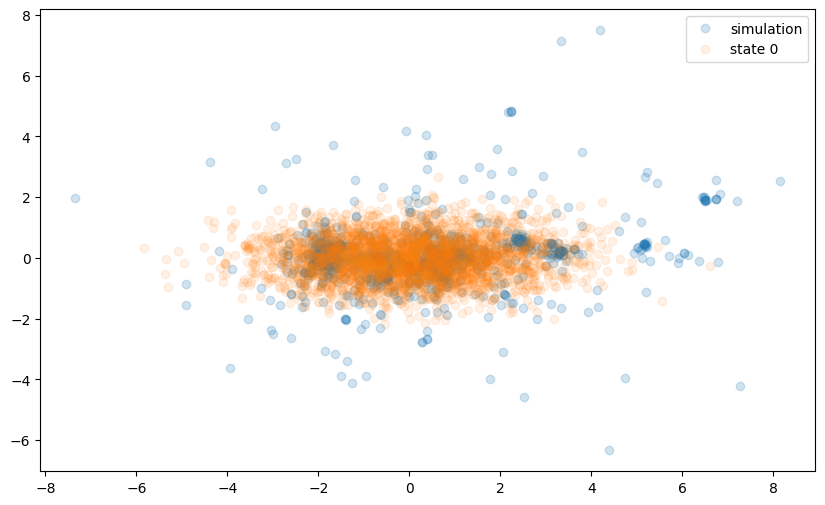

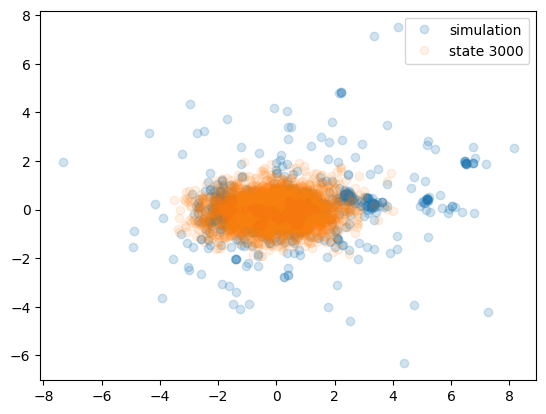

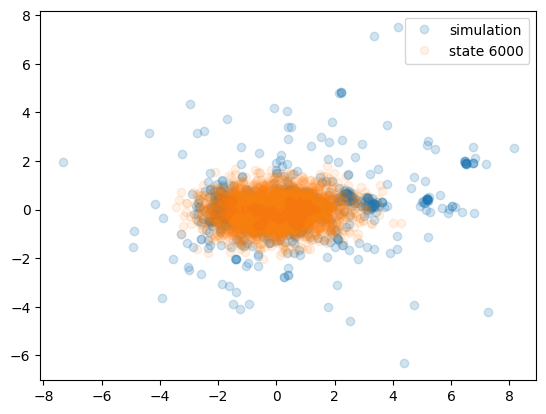

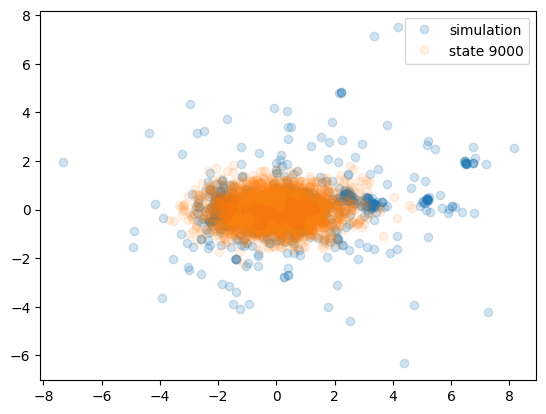

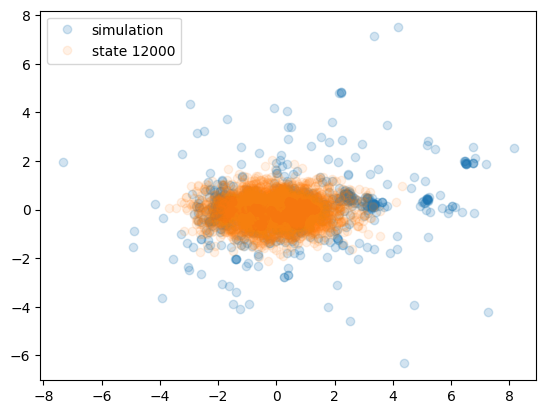

In [16]:
plt.figure(figsize=(10,6))
#plt.plot(initial_state_0[:,1], initial_state_0[:,2], 'o', alpha=0.25, label='initial state')

# plt.plot(samples[:,1], samples[:,2], 'o', alpha=0.1, label='DMCMC')
for iter, state in samples.items():
    plt.plot(X[:,1], X[:,2], 'o', alpha=0.2, label='simulation')
    plt.plot(state[:,1],state[:,2], 'o',alpha=0.1, label=f'state {iter}')
    plt.legend()
    plt.show()



In [12]:
np.save(f'{model_path}/MCMC_RW_SEED_{seed}_{timestamp}_M0.1_NO_STEP_SIZE_IT12000_acc0.006.npy', samples)
